# FX and Mean Reversion

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import numpy as np
import datetime as dt
import polars as pl
import matplotlib.pyplot as plt
import plotnine as p9

plt.rcParams['figure.figsize'] = [12, 8]
p9.options.figure_size = [12, 8]

## Define Functions

In [3]:
def get_data():
    excel = pl.read_excel('raw_ccy_irdata.xlsx', sheet_id=0)
    return excel['CCY'], excel['IR']

## Load Data

In [4]:
ccy, ir = get_data()

## Data Preparation

In [5]:
ccy_data = (
    ccy
    .rename({'Dates': 'dates'})
    .unpivot(index='dates', variable_name='ccy', value_name='px')
    .with_columns(
        pl.when(
            pl.col('ccy').str.slice(0,3) == "USD"
        ).then(
            1 / pl.col('px')
        ).otherwise(
            pl.col('px')
        ).alias('px')
    )
    .with_columns(
        pl.col("ccy").str.replace("USD", "")
    )
    .group_by('ccy')
    .agg(
        pl.all(),
        (pl.col('px').pct_change().shift(-1)).alias('ret1'),
        (pl.col('px').pct_change().rolling_std(window_size=20, min_periods=20) * np.sqrt(252)).alias('vol'),
    )
    .explode(pl.exclude('ccy'))
)

ir_data = (
    ir
    .rename({'Dates': 'dates'})
    .with_columns(
        pl.exclude('dates', 'USD') - pl.col('USD')
    )
    .select(pl.exclude('USD'))
    .unpivot(index='dates').rename({'variable': 'ccy', 'value': 'ir'})
    .select('ccy', 'dates', 'ir')
)

## Setting Data

In [6]:
data_full = (
    ccy_data.join(ir_data, on=['dates', 'ccy'], how='inner')
    .group_by('ccy', maintain_order=True)
    .agg(
        pl.all(),
        (pl.col('px') / pl.col('px').first()).alias('pxi')
    )
    .explode(pl.exclude('ccy'))
    .select('dates', 'ccy', 'px', 'ir', 'pxi', 'ret1', 'vol')
    .rename({'ccy': 'ticker', 'ir': 'ir_diff'})

    .unpivot(on=['px', 'ir_diff', 'pxi', 'ret1', 'vol'], index=['dates', 'ticker'])
    .sort(by=['dates', 'ticker'])
)    

## CCY Evolution

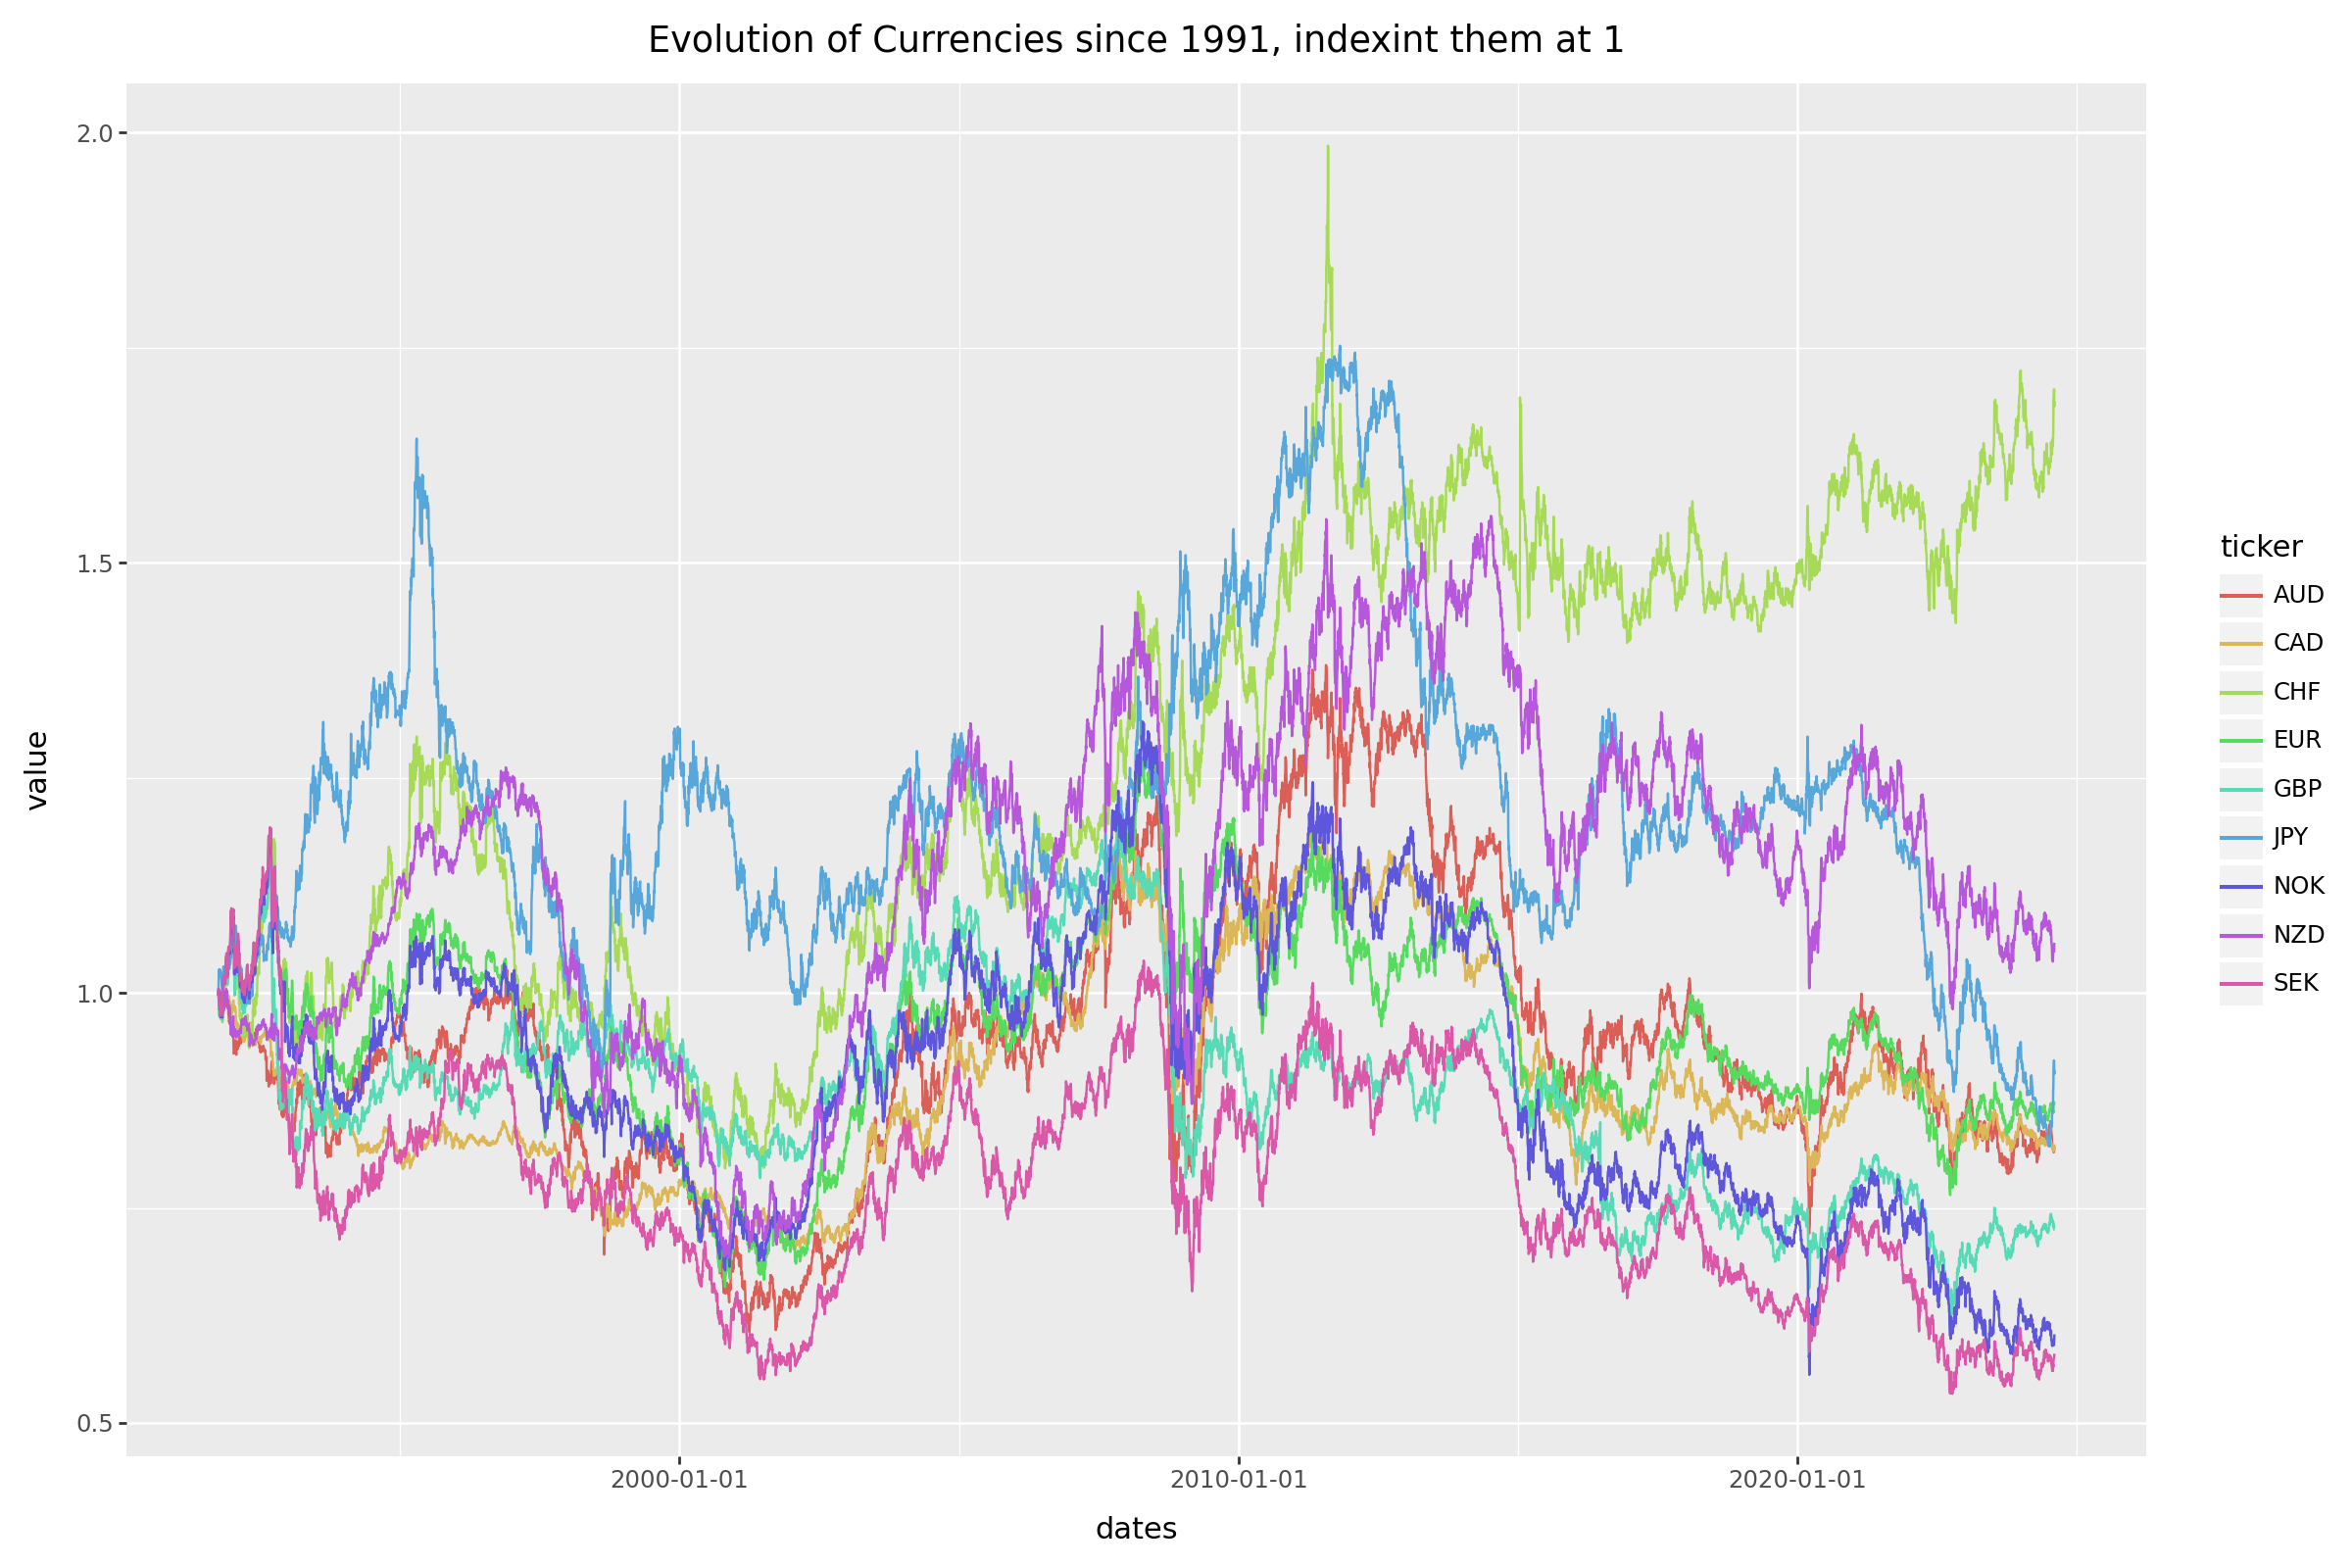

In [8]:
(
    data_full.filter(pl.col('variable') == 'pxi')
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='value', color='ticker')
    + p9.geom_line()
    + p9.ggtitle('Evolution of Currencies since 1991, indexint them at 1')
    
)

## Time Series Alpha Generation

In [9]:
LOOKBACK = 120

data_alpha = (
    data_full
    .filter(pl.col('variable') == 'px')
    .select('ticker', 'dates', 'value')
    .group_by('ticker', maintain_order=True)
    .agg(
        pl.exclude('value'),
        (-pl.col('value').pct_change(LOOKBACK)).alias('value')  
    )
    .with_columns(
        pl.col('value').list.eval(
            pl.element().rolling_mean(window_size=LOOKBACK, min_periods=LOOKBACK)
        ).alias('mn'),
        pl.col('value').list.eval(
            pl.element().rolling_std(window_size=LOOKBACK, min_periods=LOOKBACK)
        ).alias('st'),
    )
    .explode(pl.exclude('ticker'))
    .with_columns(
        ( (pl.col('value') - pl.col('mn')) / pl.col('st') ).alias('alpha'),
    )
    .select('ticker', 'dates', 'alpha')
    .unpivot(on=['alpha'], index=['ticker', 'dates'])
    .select('dates', 'ticker', 'variable', 'value')
    
    .vstack(data_full)
    .sort(by=['dates', 'ticker'])
)

## Checking Alpha vs Price Levels

Text(0.5, 1.0, 'Signal (orange) vs AUD Level (blue)')

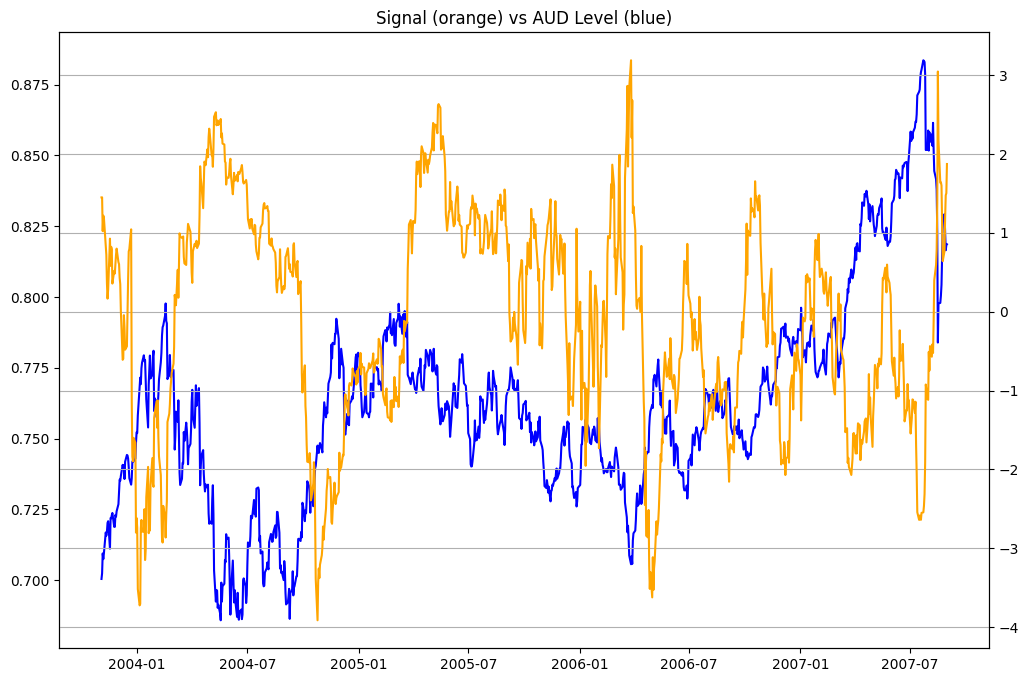

In [10]:
plt_data = (
    data_alpha
    .filter((pl.col('variable') == 'alpha') | (pl.col('variable') == 'px'))
    .filter(pl.col('ticker') == 'AUD')
    .filter((pl.col('dates') >= dt.datetime(2003,11,1)) & (pl.col('dates') < dt.datetime(2007,9,1)))
)

alpha = plt_data.filter(pl.col('variable') == 'alpha')['value']
px = plt_data.filter(pl.col('variable') == 'px')['value']
x = plt_data['dates'].unique()

fig, ax1 = plt.subplots()
ax1.plot(x, px, color='blue')
ax2 = ax1.twinx()
ax2.plot(x, alpha, color='orange')
plt.grid()
plt.title('Signal (orange) vs AUD Level (blue)')

## Cumulative PL on Alpha over Test Set

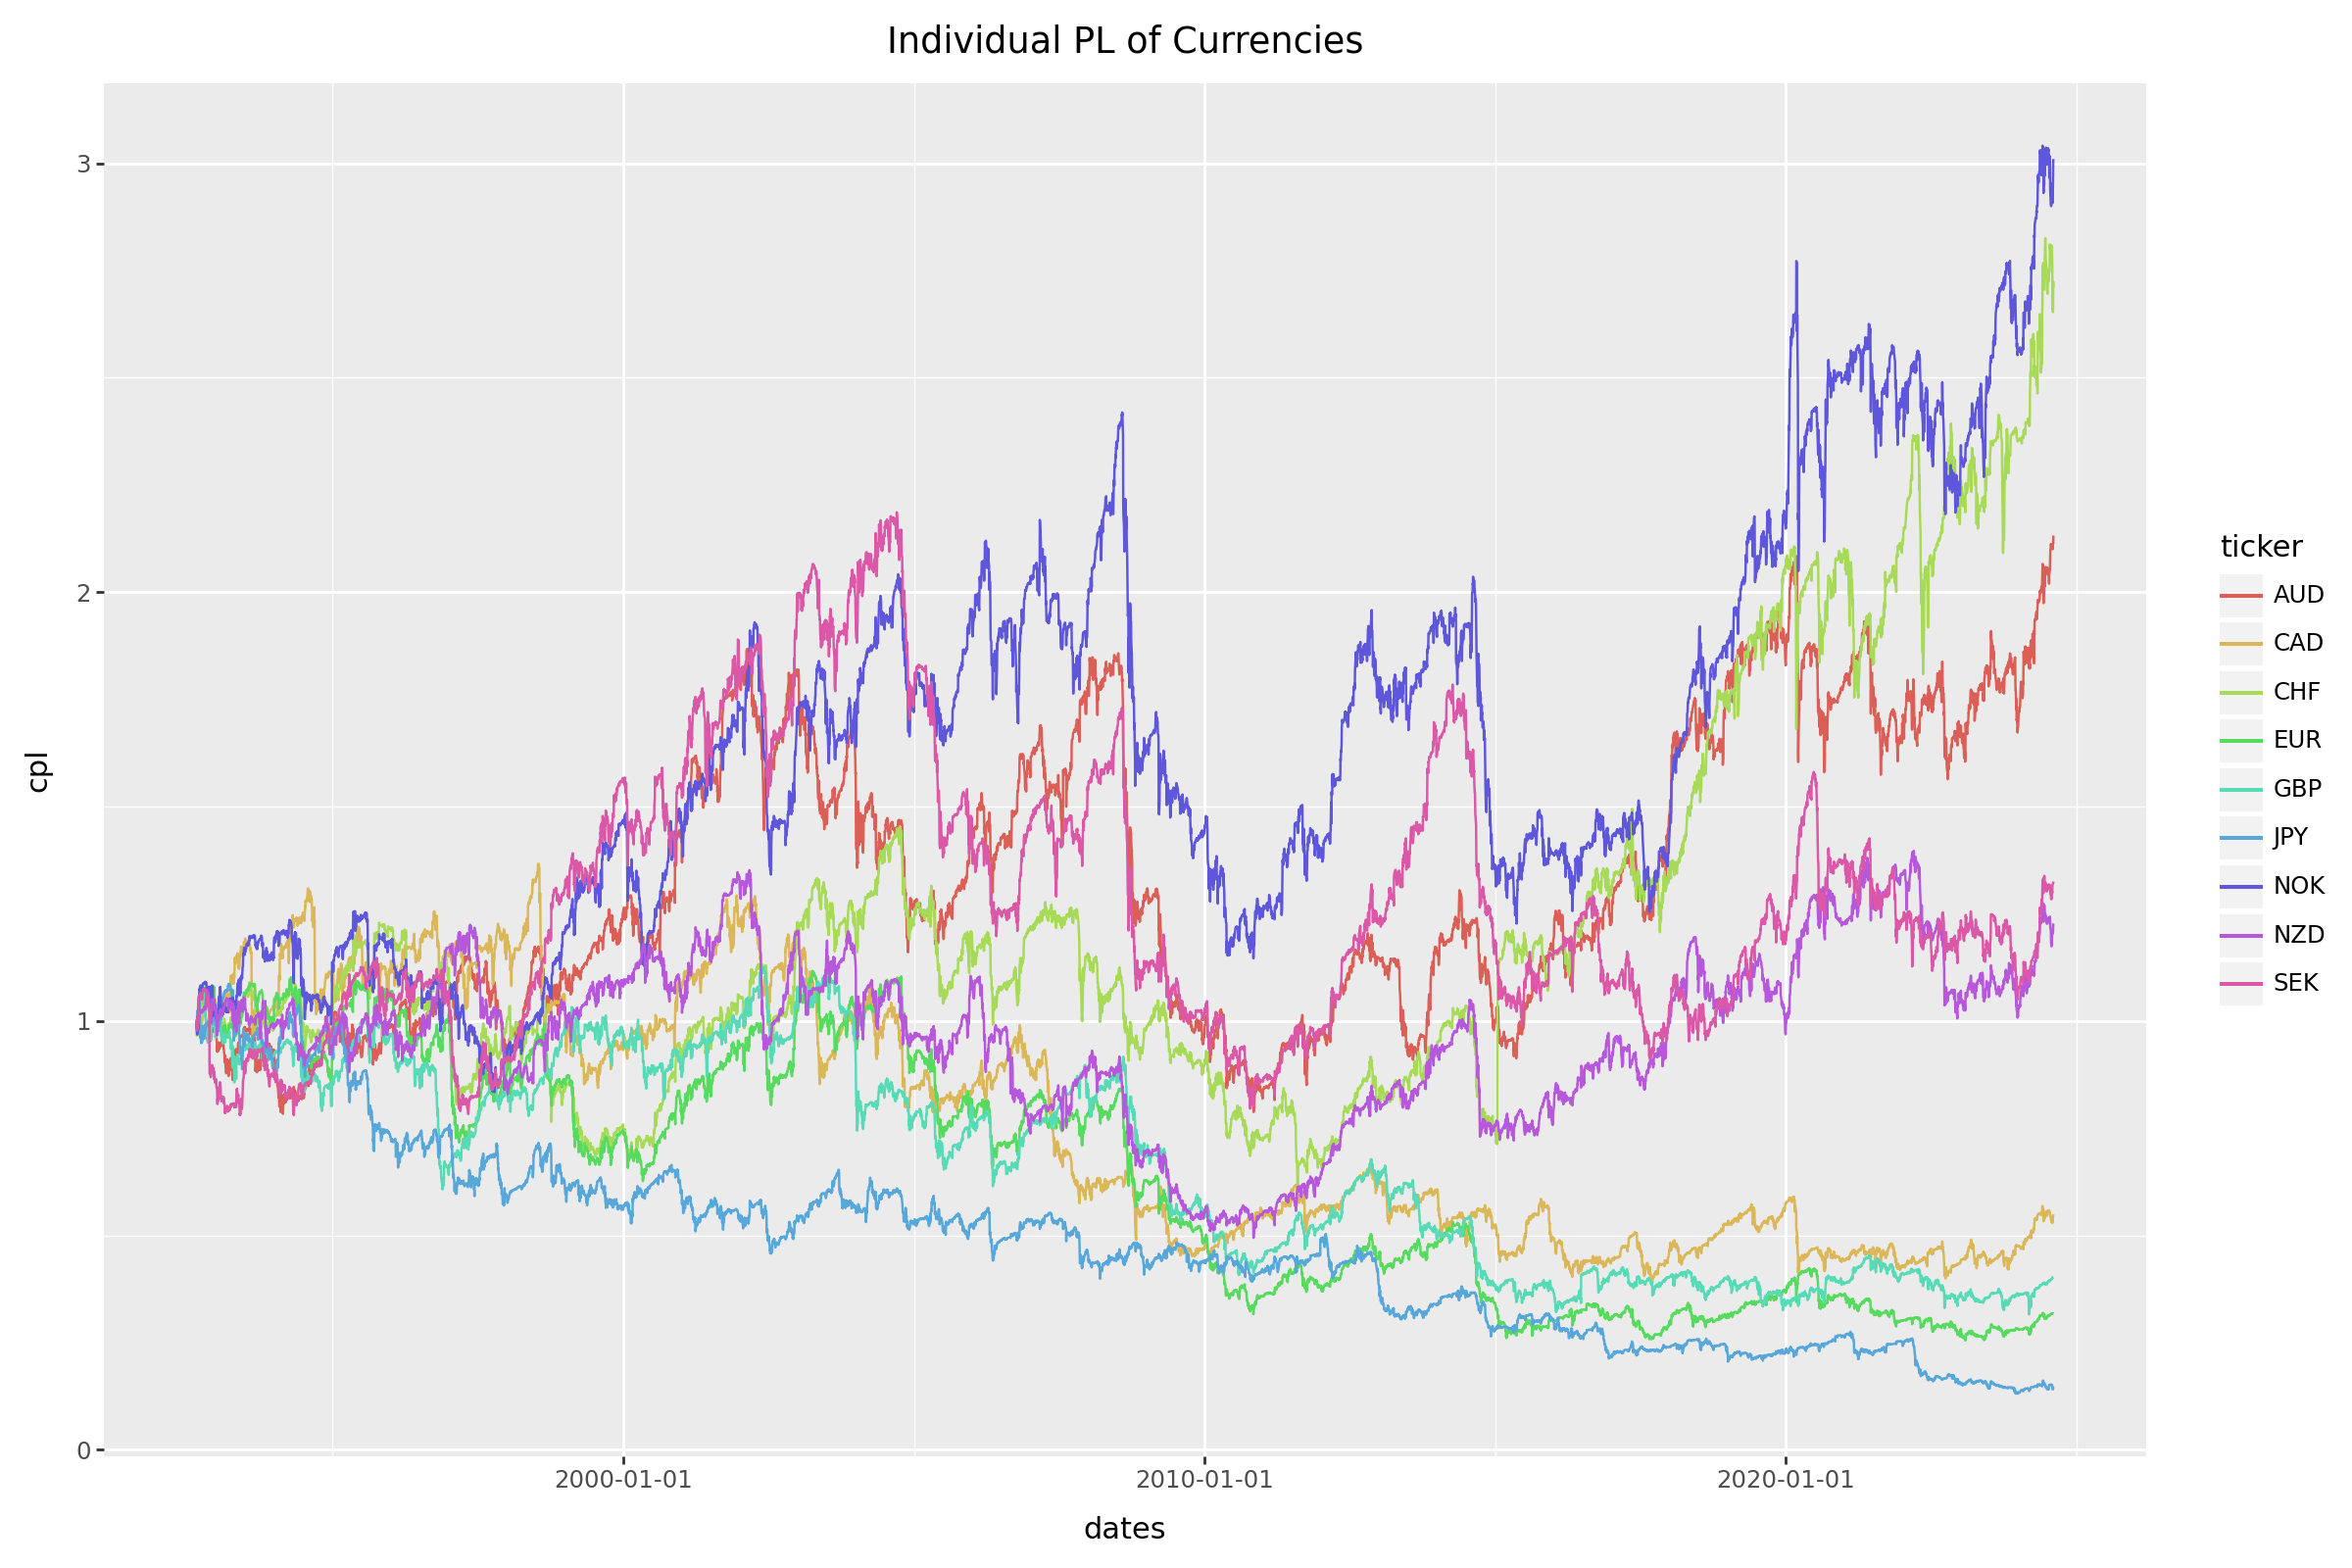

In [11]:
(
    data_alpha#.filter(pl.col('dates') < dt.datetime(2016, 1, 1))
    .pivot(on='variable', index=['dates', 'ticker'])
    .group_by('ticker', maintain_order=True)
    .agg(
        pl.exclude('ticker'),
        ( 1+ pl.col('alpha')  * pl.col('ret1')  / pl.col('vol') * 0.1).cum_prod().alias('cpl')
    )
    .explode(pl.exclude('ticker'))
    .select('dates', 'ticker', 'cpl')
    .drop_nulls()
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='cpl', color='ticker')
    + p9.geom_line()
    + p9.ggtitle('Individual PL of Currencies')
)

## Cumulative PL over equally weighted portfolio

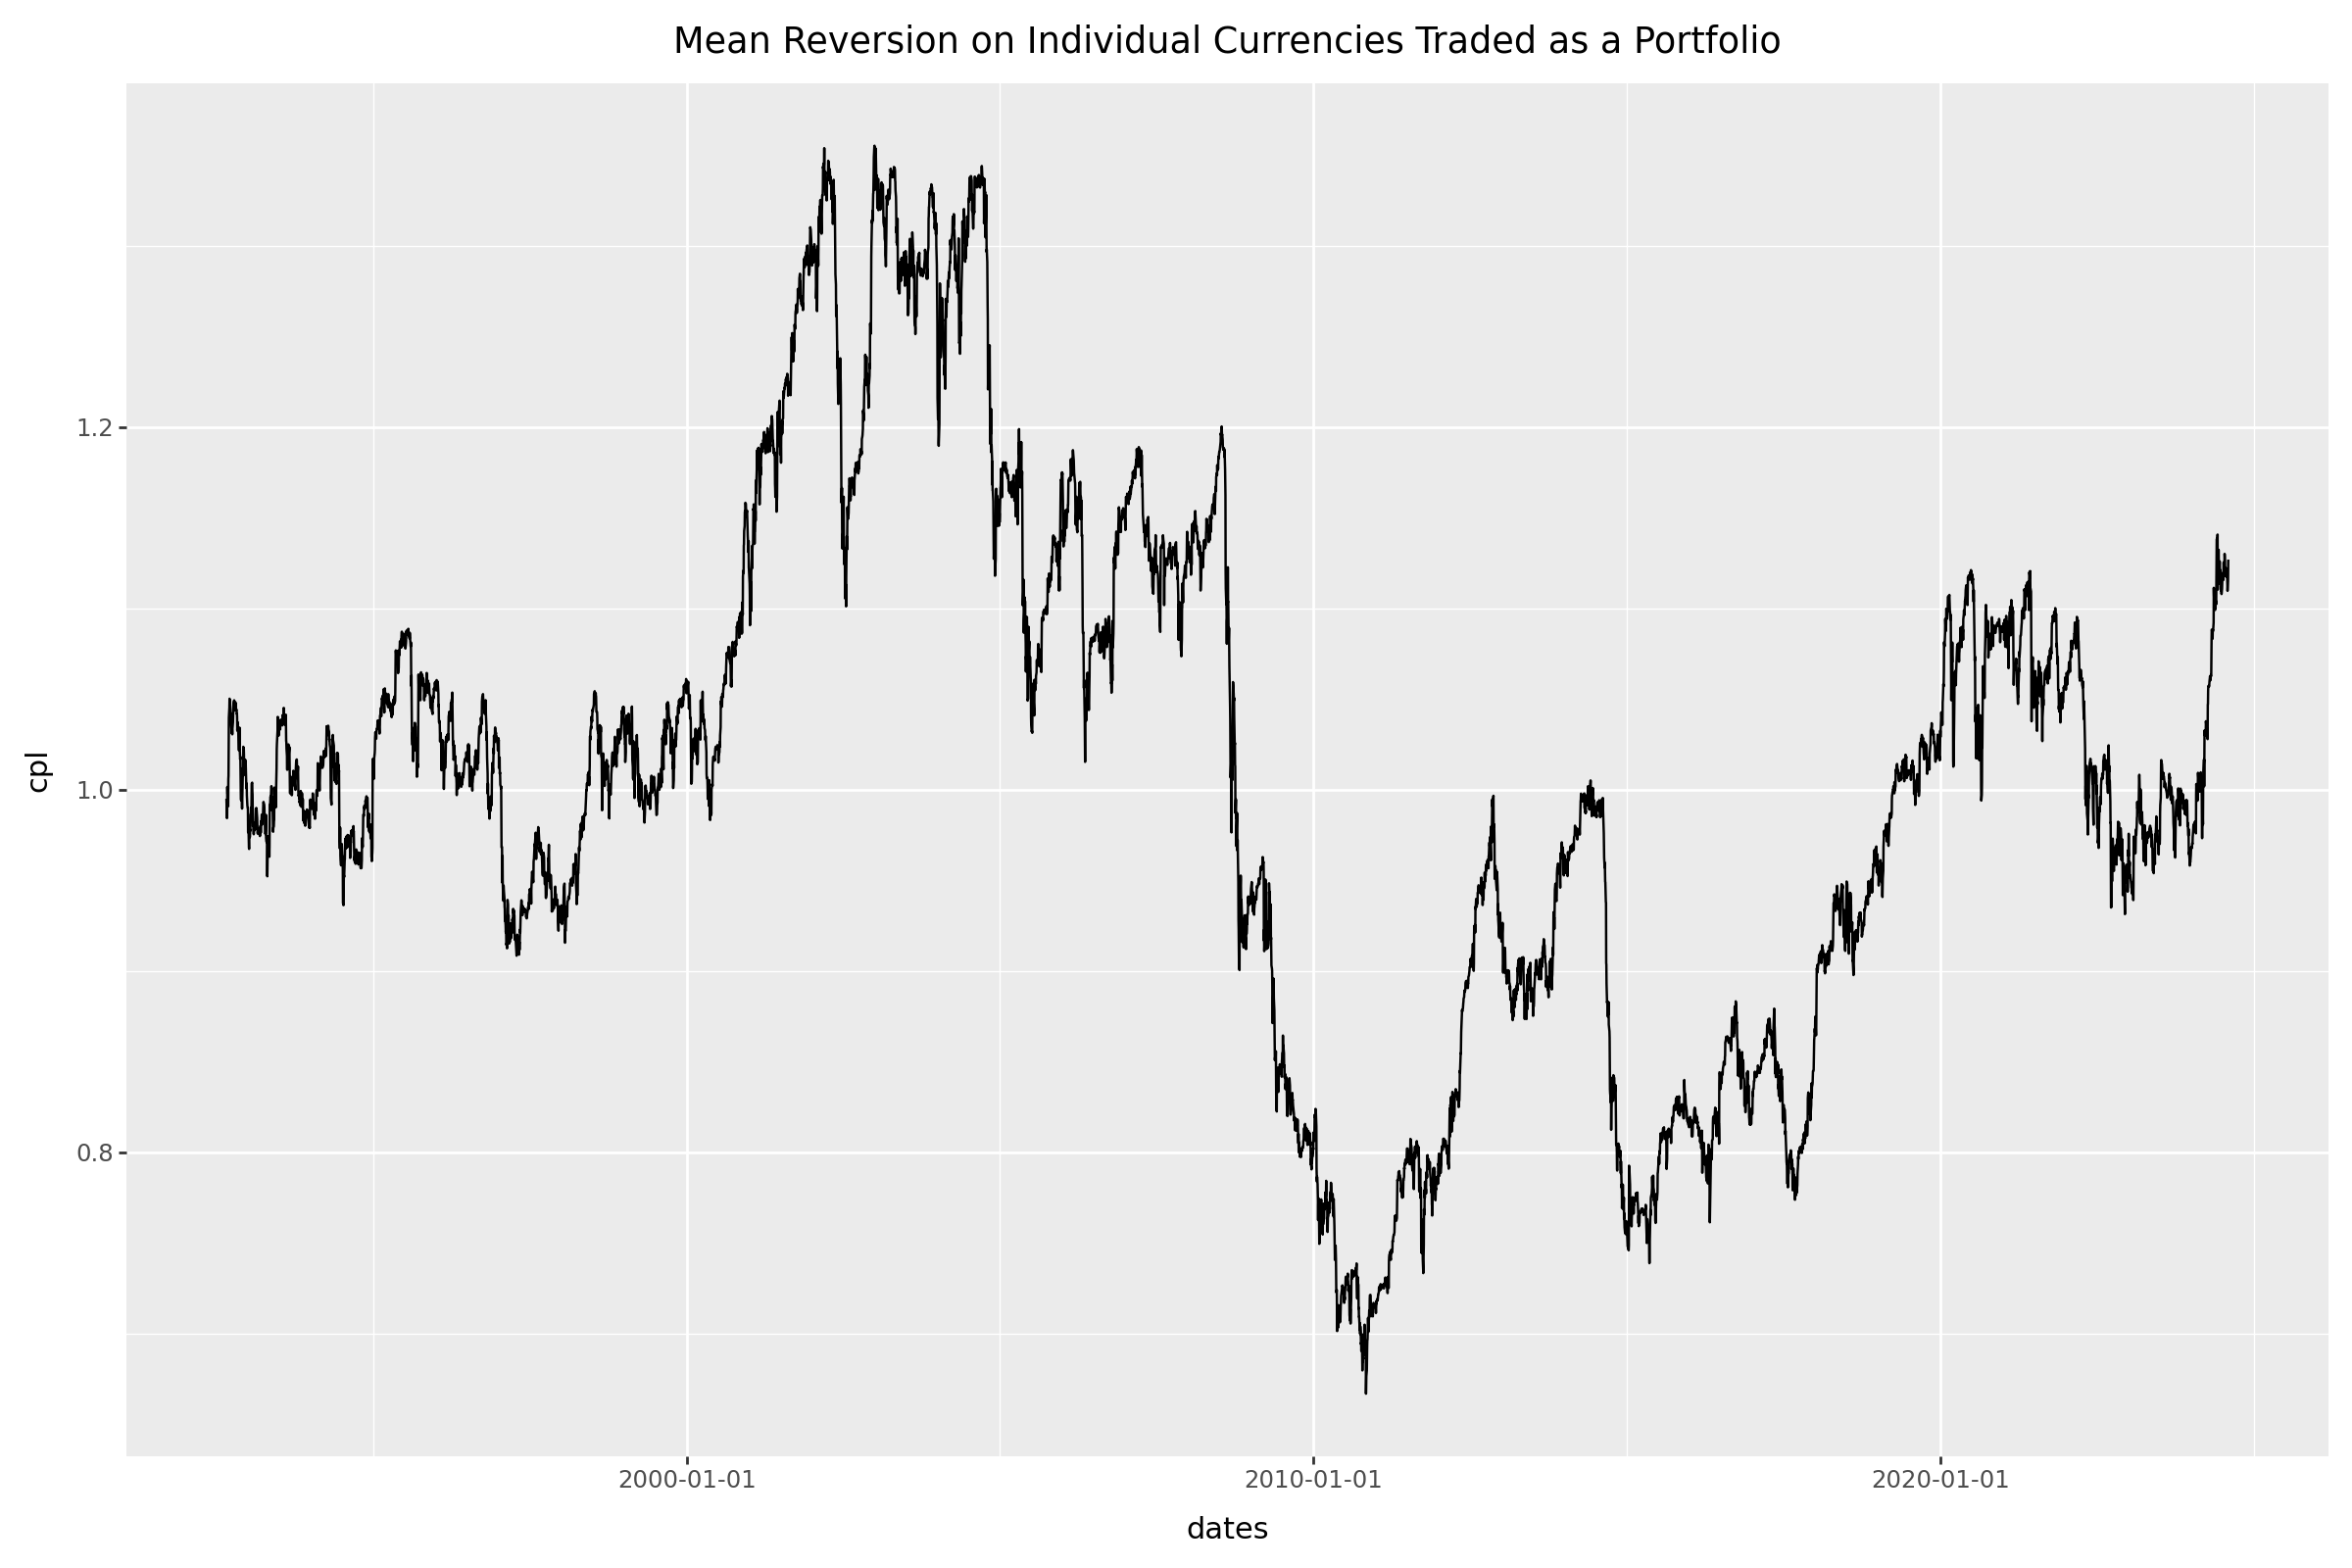

In [12]:
(
    data_alpha#.filter(pl.col('dates') < dt.datetime(2016, 1, 1))
    .pivot(on='variable', index=['dates', 'ticker'])
    .group_by('ticker', maintain_order=True)
    .agg(
        pl.exclude('ticker'),
        ( pl.col('alpha') * pl.col('ret1') / pl.col('vol') * 0.1).alias('pl')
    )
    .explode(pl.exclude('ticker'))

    .group_by('dates', maintain_order=True)
    .agg(
        pl.col('pl').mean()
    )
    .drop_nulls()
    .with_columns(
        (1 + pl.col('pl')).cum_prod().alias('cpl')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='cpl')
    + p9.geom_line()
    + p9.ggtitle('Mean Reversion on Individual Currencies Traded as a Portfolio')
)

## Basket of Currencies

In [15]:
commod = ['AUD', 'NZD'] # Cad seems to play up.
eur_srvc = ['EUR', 'CHF', 'GBP', 'NOK', 'SEK']   # Leaving out JPY since it isn'g Eurozone

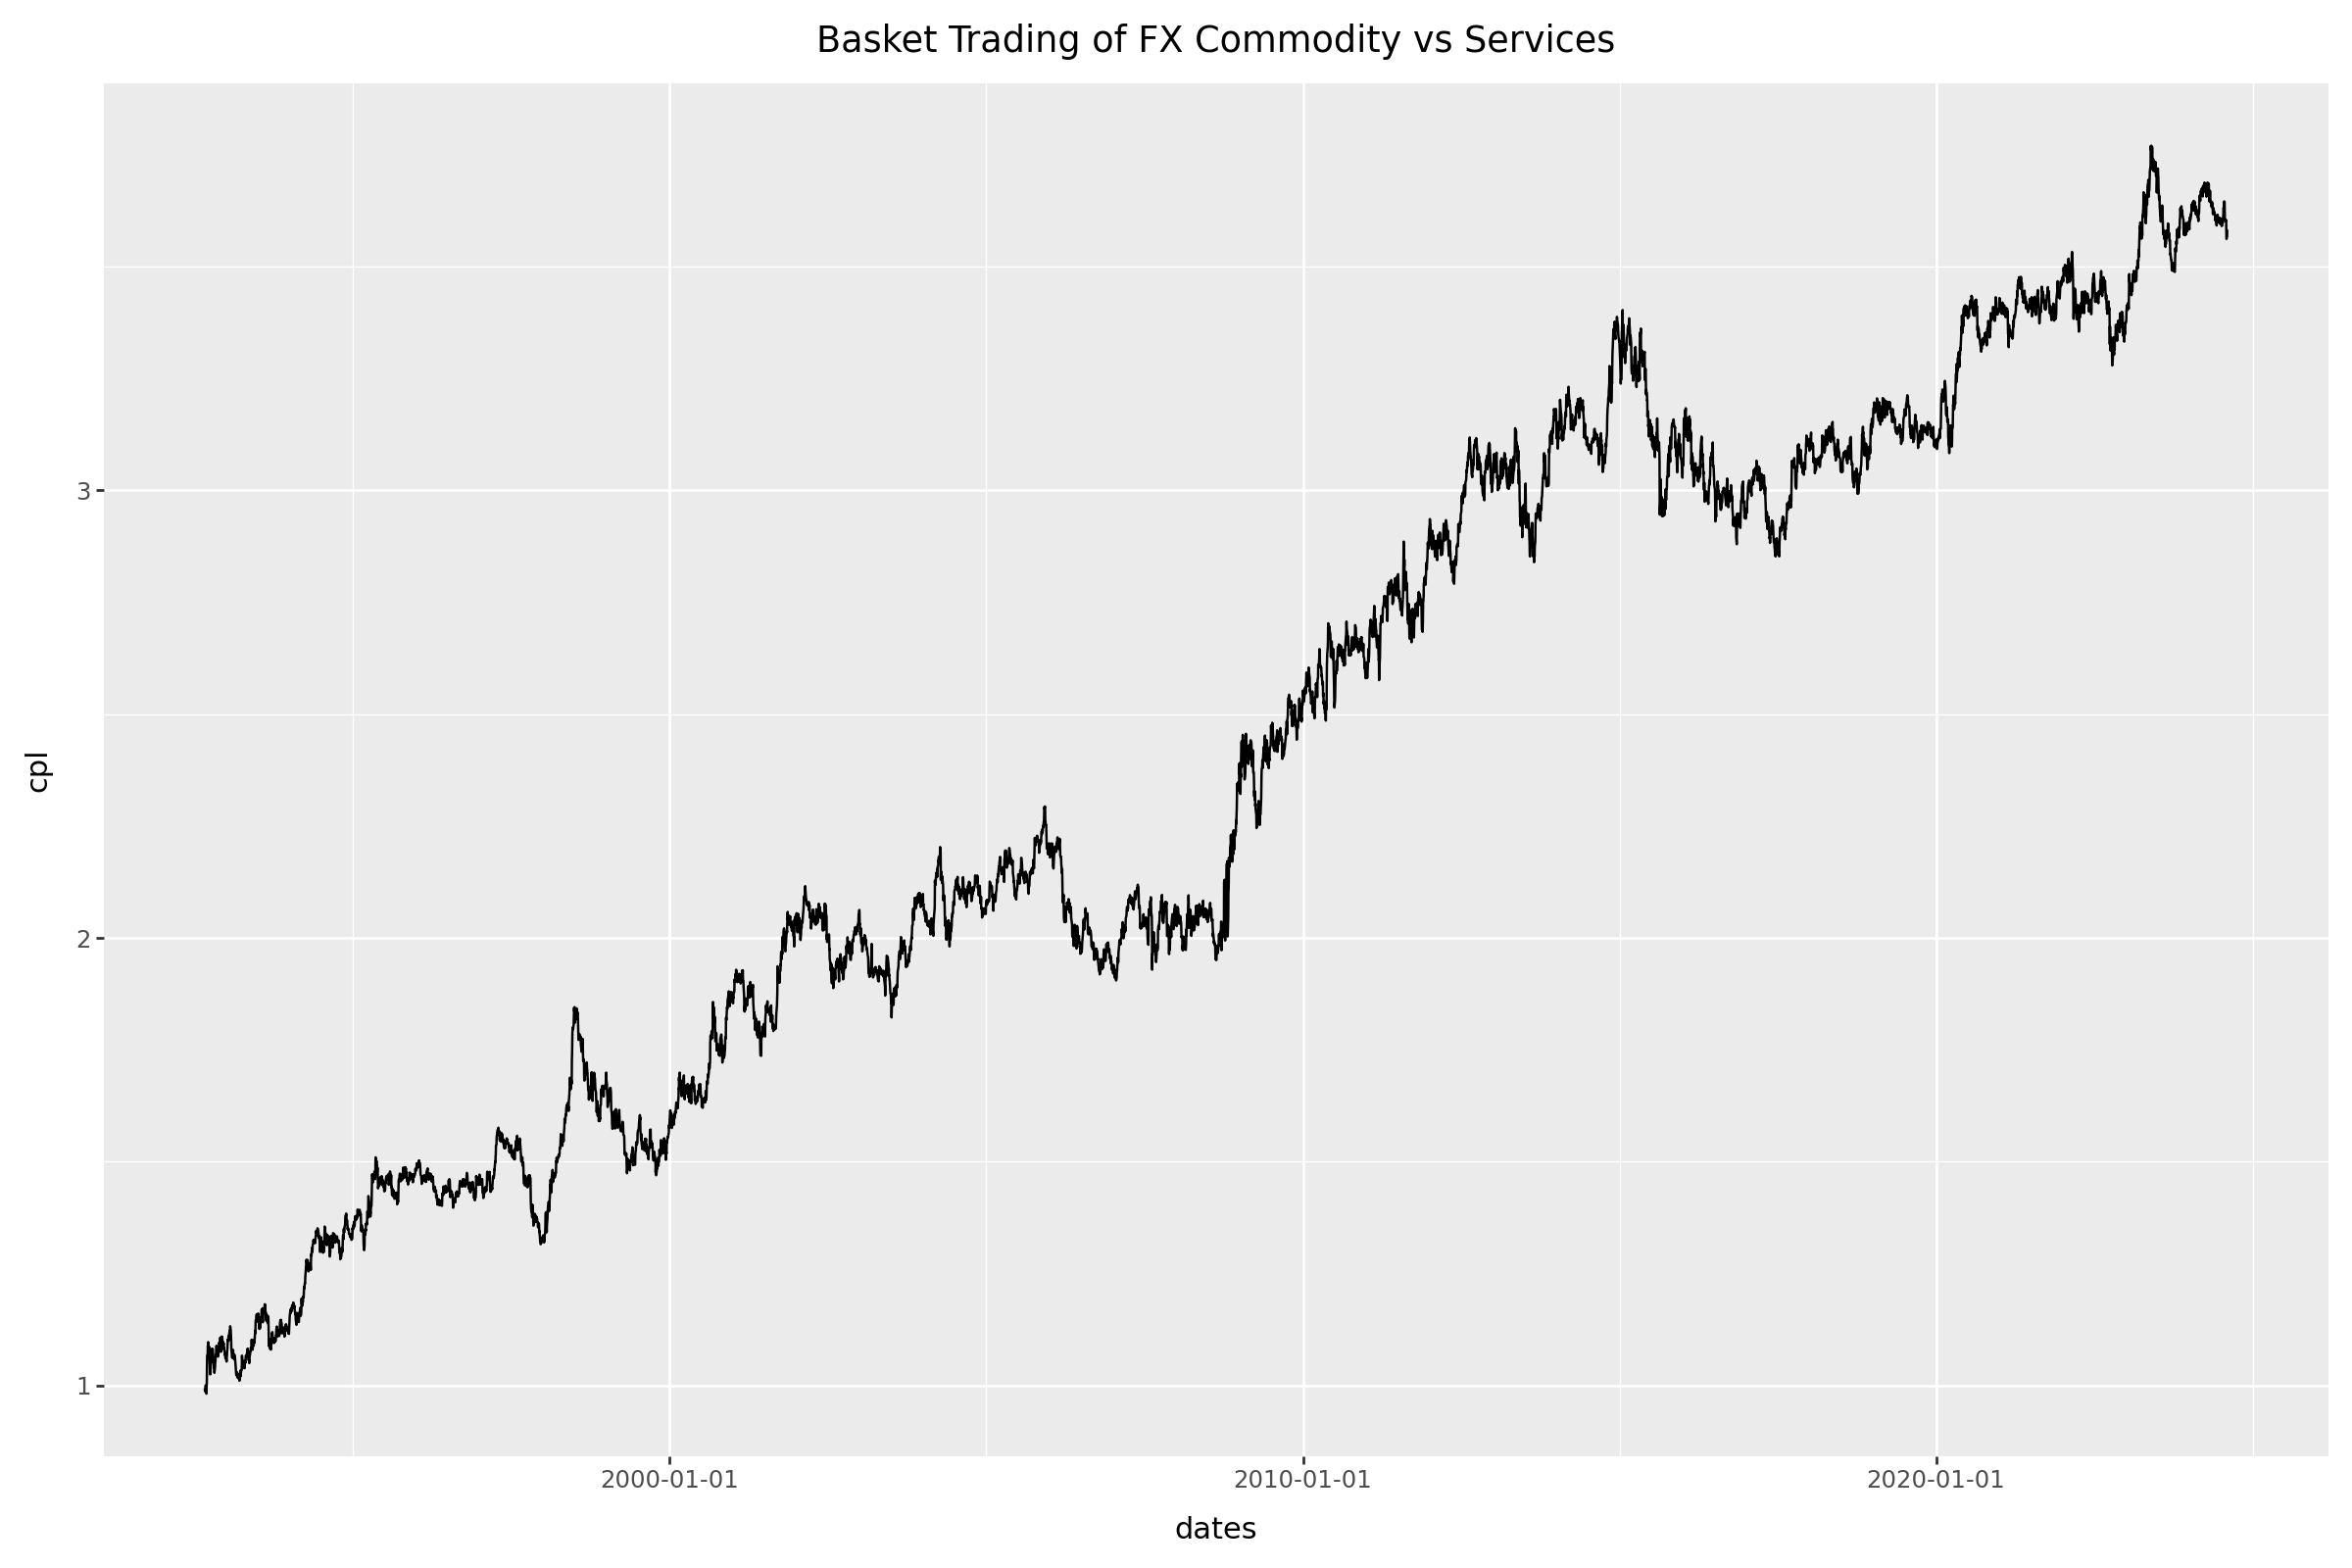

In [37]:
data_baskets = (
    data_alpha
    .pivot(on='variable', index=['dates', 'ticker'])
    .with_columns(
        pl.when(pl.col('ticker').is_in(commod)).then(0).when(pl.col('ticker').is_in(eur_srvc)).then(1).otherwise(2).alias('bloc')
    )
    .filter(pl.col('bloc') != 2)
    .group_by(['dates', 'bloc'], maintain_order=True)
    .agg(
        pl.col('alpha').mean(),
        pl.col('ret1').mean()
    )
    .fill_nan(None).drop_nulls()
    .pivot(on='bloc', index='dates')
    .with_columns(
        (pl.when(pl.col('alpha_0') > pl.col('alpha_1')).then(pl.col('ret1_0') - pl.col('ret1_1')).otherwise(- pl.col('ret1_0') + pl.col('ret1_1'))).alias('pl')
    )
    .with_columns(
        (1 + pl.col('pl')).cum_prod().alias('cpl')
    )
    .select('dates', 'cpl')
)

(   
    data_baskets
    .pipe(p9.ggplot)
    + p9.aes(x='dates', y='cpl')
    + p9.geom_line()
    + p9.ggtitle('Basket Trading of FX Commodity vs Services')
)


In [46]:
tm = (data_baskets['dates'][-1] - data_baskets['dates'][0]).days / 365
cagr = (data_baskets['cpl'][-1] / data_baskets['cpl'][0]) ** (1/tm) - 1
vol = data_baskets['cpl'].pct_change().std() * np.sqrt(252)

print(f"CAGR: {cagr*100:.2f}%, Vol: {vol*100:.2f}%, Sharpe Ratio: {(cagr/vol):.2f}")

CAGR: 4.09%, Vol: 9.23%, Sharpe Ratio: 0.44
